# APLR Using Tesseract-ocr & TensorFlow

## Old Version Of TensorFlow is used

In [23]:
!sudo apt install tesseract-ocr
!pip uninstall tensorflow --y
!pip install tensorflow==1.12.0
!pip install pytesseract
!pip install tensorflow-object-detection-api


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Uninstalling tensorflow-1.12.0:
  Successfully uninstalled tensorflow-1.12.0
  Using cached https://files.pythonhosted.org/packages/22/cc/ca70b78087015d21c5f3f93694107f34ebccb3be9624385a911d4b52ecef/tensorflow-1.12.0-cp36-cp36m-manylinux1_x86_64.whl


## All Imports 

In [24]:
import io
import os
import sys
import tarfile
import zipfile
import random
import urllib
import requests 
import json
import pickle

import cv2 
import pytesseract
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six.moves.urllib as urllib

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from io import StringIO
from PIL import Image
from google.colab import files
from urllib.request import urlopen
from distutils.version import StrictVersion
from collections import defaultdict
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

## GPU Env Setup

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

##  Define Required Methods

In [26]:
def download_and_train(df):
    Images = []
    Plates = []
    for index, row in df.iterrows():
        # Get the image from the URL
        # URL is the first "content" in a line
        resp = urllib.request.urlopen(row[0]) 
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of Number plate Boundary 
        # Multiplying given points with height and width to get the actual co-ordinates
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and keep it seperately
        completeImage = Image.fromarray(im)
        plateImage = completeImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))

    return Images, Plates

In [27]:
def cv2_convert(img_data, count):
    img = img_data
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    gray = cv2.medianBlur(gray, 3)
    path_png='png_tesseract'
    count += 1
    filename = os.path.join(path_png,'image{}.png'.format(count))
    cv2.imwrite(filename, gray)
    return filename

In [28]:
def verify_char(tex):
    side=tex
    az='ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890' # Not sure abcdefghijklmnopqrstuvwxyz
    i=0
    yo=len(az)
    txt=''
    for i in range(0,yo):
        if side==az[i]:
            txt=az[i]
            break
    return txt   

In [29]:
def rectify_plate_characters(text):
    tex = text
    out1=[]
    size=len(tex)
    for i in range(0,size):
      if tex[i]==verify_char(tex[i]):
        out1.append(tex[i])
    yup=''.join(str(e) for e in out1)    
    return yup

In [30]:
def longest_str(arr):
  # Longest String in list 
  # using loop 
  max_len = -1
  for ele in arr: 
      if len(ele) > max_len: 
          max_len = len(ele) 
          res = ele 
  return res

In [31]:
def img_to_text(img_data):
  txtArr = []
  for i in range(1, 2, 3):
      for j in range(3, 14):
          if (j != 5):
            config = ('--oem ' + str(i) +' --psm ' + str(j))
            str_text = pytesseract.image_to_string(img_data, lang='eng', config=config)
            txtArr.append(str_text)
  return longest_str(txtArr)

In [32]:
def anpr_detect(image_path):
  pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' ) 
  with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
      detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      image = Image.open(image_path) 
      image_np = cv2.imread(image_path,1)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      ymin = boxes[0,0,0]
      xmin = boxes[0,0,1]
      ymax = boxes[0,0,2]
      xmax = boxes[0,0,3]
      (im_width, im_height) = image.size
      (xminn, xmaxx, yminn, ymaxx) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
      cropped_image = tf.image.crop_to_bounding_box(image_np, int(yminn), int(xminn),int(ymaxx - yminn), int(xmaxx - xminn))
      img_data = sess.run(cropped_image)
      count = 0       
      filename = cv2_convert(img_data, count)
      text = img_to_text(img_data)
      verified = rectify_plate_characters(text)
      print('CHARCTER RECOGNITION : ', verified)
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=5)      
      plt.figure(figsize=IMAGE_SIZE)
      plt.subplot(1,2,1)
      plt.imshow(image)
      plt.subplot(1,2,2)
      plt.imshow(img_data)
      plt.show()
      return verified

In [33]:
# Read the pickle file from from Sanjeeb Talukdar's Git Repo
PATH_TO_PICKLE = 'https://github.com/sanjeeb-talukdar/anpr-tensorflow/raw/main/anpr.pb'
# Read the json from from Sanjeeb Talukdar's Git Repo
PATH_TO_JSON = 'https://raw.githubusercontent.com/sanjeeb-talukdar/anpr-tensorflow/main/anpr.json'

PATH_TO_LABELS = 'anpr.pbtxt'
file = open('anpr.pbtxt', 'w+')

NUM_CLASSES = 1
IMAGE_SIZE = (12, 8)

# Read the json from from Sanjeeb Talukdar's Git Repo
data = pd.read_json(PATH_TO_JSON, lines=True)
pd.set_option('display.max_colwidth', None)

# Data Preprocessing
# Delete the empty column
del data['extras']

# Extract the Box of number plate via points provided
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# Data cleaning
# And drop the rest of the annotation info
del data['annotation']

# Load Trainin Data
Images , Plates = download_and_train(data)

# Load label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [34]:
# Using pickle to store the python list locally so that extracting images from url is not required again
# Python lists of car images and number plates are saved in list
print("Data Loading...Wait")
with open('anpr_img_train', 'wb') as f:
    pickle.dump(Images, f)
with open('anpr_plate_train', 'wb') as f:
    pickle.dump(Plates, f)
print("Data Saved")

Data Loading...Wait
Data Saved


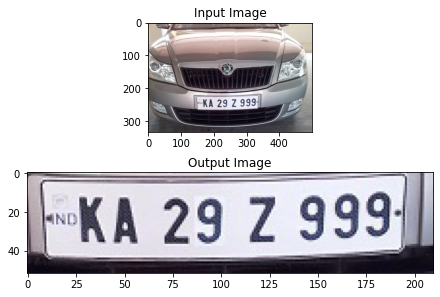

In [35]:
# The Locally saved python list can be accesed easily for images
with open('anpr_img_train', 'rb') as f:
    mylist1 = pickle.load(f)

with open('anpr_plate_train', 'rb') as f:
    mylist2 = pickle.load(f)

# Create figure and axes
fig, ax = plt.subplots(2, 1, constrained_layout=True)

# Set title
ax[0].set_title('Input Image')
ax[1].set_title('Output Image')

# Display the images
# Car
tt=random.randint(0, 235)
ax[0].imshow(mylist1[tt])
# Number plate
ax[1].imshow(mylist2[tt])

plt.show()

### Load frozen model (pickle) into memory.

In [36]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  file = urlopen(PATH_TO_PICKLE)
  decoded_line = file.read()
  od_graph_def = tf.GraphDef()
  od_graph_def.ParseFromString(decoded_line)
  tf.import_graph_def(od_graph_def, name='')
  

## Detection (Multiple Files Supported)

Saving 9.jpg to 9.jpg
CHARCTER RECOGNITION :  TS28B34243


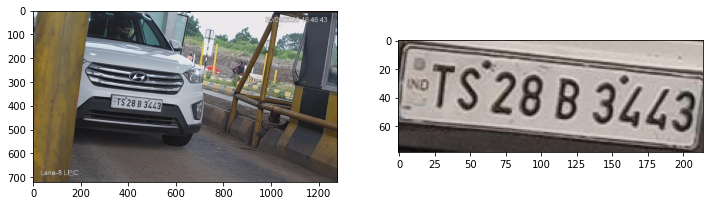

In [37]:
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images
  anpr_detect(fn)
 